# Image Cow Recognition - Cow Detection

## Imports

In [1]:
# import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt 
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
import numpy as np 
import cv2
import warnings
warnings.filterwarnings('ignore')
import image_slicer
import os
import tqdm

/home/ec2-user/cow_demo/lib64/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model and presets

This basically loads the pretrained faster rcnn resnet50 model from the torch vision library

In [2]:
# load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# send to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# set to evaluation mode
model.eval()

# load the COCO dataset category names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# we want to capture anything that may look like a cow in the wildlife
DESIRED_CLASS = [
    'cat',
    'dog',
    'horse',
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    
]

In [3]:
def get_prediction(img_path, confidence):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """

  # read image and transform to tensor
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img).to(device)

  # put into the model
  pred = model([img])

  # read the predicted class and box
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].detach().cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())

  # filter out those objects that are below the confidence
  pred_t = [pred_score.index(x) for x in pred_score if x>confidence]
  if(len(pred_t) == 0):
    return [], []
  pred_t = pred_t[-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [4]:
def detect_object(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  # Read the image
  image = cv2.imread(img_path)
  HEIGHT, WIDTH = image.shape[0:2]
  cow_count = 0

  # Slice the images into defined slices
  num_slice = 4
  slices = image_slicer.slice(img_path, num_slice)
  num_slice = len(slices)
  
  
  dim =  int(np.sqrt(num_slice))
  sheight = HEIGHT // dim
  swidth = WIDTH // dim


  image_coordinates = []

  # predict for each slice
  for i in range(0, dim):
    for j in range(0, dim):
      # get the slcied image
      sliced = slices[i * dim + j]
      sliced_path = sliced.generate_filename(prefix=img_path[:-4], path=False)

      # predict the selected slice
      boxes, pred_cls = get_prediction(sliced_path, confidence)

      # for each box, draw to the original image
      for k in range(len(boxes)):
        if pred_cls[k] in DESIRED_CLASS:
          cow_count += 1
          c1 = (int(boxes[k][0][0] + j * swidth), int(boxes[k][0][1] + i * sheight))
          c2 = (int(boxes[k][1][0] + j * swidth), int(boxes[k][1][1] + i * sheight))
          mid_x = (c2[0] + c1[0]) // 2
          mid_y = (c2[1] + c1[1]) // 2
          image_coordinates.append([mid_x, mid_y])
          cv2.rectangle(image, c1, c2, color=(0, 255, 0), thickness=rect_th)
          cv2.putText(image, 'cow', c1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

      # remove the sliced image from the directory
      os.remove(sliced_path)
  return image, cow_count, image_coordinates

  0%|          | 0/8 [00:00<?, ?it/s]

./cow_boxed/Fall (cow)/TW2_C1_S (08222019).JPG
cow_boxed/Fall (cow)


  0%|          | 0/8 [00:16<?, ?it/s]


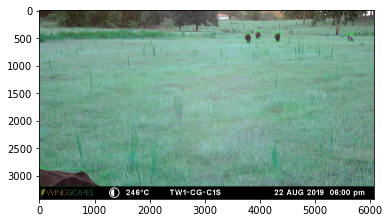

In [9]:
data = []
DATA_DIR = "./cow_images"
CONFIDENCE = 0.42
OUTPUT_IMAGE_DIR = "cow_boxed"
OUTPUT_RESULT_DIR = "./cow_count_output.txt"
if not os.path.exists(OUTPUT_IMAGE_DIR):
    os.mkdir(OUTPUT_IMAGE_DIR)

# write to the result text
f = open(OUTPUT_RESULT_DIR, 'w')
# loop through all the images
for folders in tqdm.tqdm(os.listdir(DATA_DIR)):
    for files in os.listdir(f"{DATA_DIR}/{folders}"):
        folder_dir = f"{DATA_DIR}/{folders}/"
        file_dir = f"{DATA_DIR}/{folders}/{files}"
        # check to see if the file exists
        if os.path.exists(file_dir):
            cow_image, cow_count, image_coordinates = detect_object(file_dir, confidence=CONFIDENCE)
            new_file_dir = file_dir.replace("cow_images", OUTPUT_IMAGE_DIR)
            # Write the new boxed images
            print(new_file_dir)
            print(f"{OUTPUT_IMAGE_DIR}/{folders}")
            if not os.path.exists(f"{OUTPUT_IMAGE_DIR}/{folders}"):
                os.mkdir(f"{OUTPUT_IMAGE_DIR}/{folders}")

            cv2.imwrite(new_file_dir, cow_image)
            plt.imshow(cow_image)
            data.append([new_file_dir, cow_count, image_coordinates])
            # Write the result to the file
            f.write("%s, %d" % (new_file_dir, cow_count))
            for pt in image_coordinates:
                f.write(", (%d, %d)" % (pt[0], pt[1]))
            f.write("\n")
        break
    break
f.close() 

